In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import glob

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from sklearn.metrics import jaccard_score


tqdm.pandas()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
train_df = pd.read_csv('train.csv')
print("Training Data:" , train_df.shape)

test_df = pd.read_csv('test.csv')
print("Test Data:" , test_df.shape)

Training Data: (1200000, 21)
Test Data: (800000, 20)


In [ ]:


#Drop ID
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

In [ ]:
#Age nan values
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())

#Annual Income nan values
train_df['Annual Income'] = train_df['Annual Income'].fillna(train_df['Annual Income'].mean())
test_df['Annual Income'] = test_df['Annual Income'].fillna(test_df['Annual Income'].mean())

#marital status nan values
train_df['Marital Status'] = train_df['Marital Status'].fillna('other')
test_df['Marital Status'] = test_df['Marital Status'].fillna('other')

#Number of Dependents nan values
train_df['Number of Dependents'] = train_df['Number of Dependents'].fillna(0)
test_df['Number of Dependents'] = test_df['Number of Dependents'].fillna(0)

#Occupation nan values
train_df['Occupation'] = train_df['Occupation'].fillna('other')
test_df['Occupation'] = test_df['Occupation'].fillna('other')

#Health Score nan values
train_df['Health Score'] = train_df['Health Score'].fillna(train_df['Health Score'].mode()[0])
test_df['Health Score'] = test_df['Health Score'].fillna(test_df['Health Score'].mode()[0])

#Previous Claims nan values
train_df['Previous Claims'] = train_df['Previous Claims'].fillna(train_df['Previous Claims'].mode()[0])
test_df['Previous Claims'] = test_df['Previous Claims'].fillna(test_df['Previous Claims'].mode()[0])

#Vehicle Age nan values
train_df['Vehicle Age'] = train_df['Vehicle Age'].fillna(train_df['Vehicle Age'].mode()[0])
test_df['Vehicle Age'] = test_df['Vehicle Age'].fillna(test_df['Vehicle Age'].mode()[0])

#Credit Score nan values
train_df['Credit Score'] = train_df['Credit Score'].fillna(train_df['Credit Score'].mean())
test_df['Credit Score'] = test_df['Credit Score'].fillna(test_df['Credit Score'].mean())

#Insurance Duration nan values
train_df['Insurance Duration'] = train_df['Insurance Duration'].fillna(train_df['Insurance Duration'].mode()[0])
test_df['Insurance Duration'] = test_df['Insurance Duration'].fillna(test_df['Insurance Duration'].mode()[0])

#Customer Feedback nan values
train_df['Customer Feedback'] = train_df['Customer Feedback'].fillna('other')
test_df['Customer Feedback'] = test_df['Customer Feedback'].fillna('other')

# Policy Start Date  nan values
train_df['Policy Start Date'] = train_df['Policy Start Date'].fillna(train_df['Policy Start Date'].mode()[0])
test_df['Policy Start Date'] = test_df['Policy Start Date'].fillna(test_df['Policy Start Date'].mode()[0])

train_df.head()
test_df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,28.0,Female,2310.0,other,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,0.0,19.0,592.904749,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,0.0,14.0,372.000000,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,0.0,16.0,819.000000,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.000000,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,0.0,14.0,755.000000,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


In [ ]:
#Policy Start Date drop 
train_df['Policy Start Date'] = pd.to_datetime(train_df['Policy Start Date'])
test_df['Policy Start Date'] = pd.to_datetime(test_df['Policy Start Date'])

train_df['Policy Year'] = train_df['Policy Start Date'].dt.year
train_df['Policy Month'] = train_df['Policy Start Date'].dt.month
train_df['Policy Week'] = train_df['Policy Start Date'].dt.weekday

test_df['Policy Year'] = test_df['Policy Start Date'].dt.year
test_df['Policy Month'] = test_df['Policy Start Date'].dt.month
test_df['Policy Week'] = test_df['Policy Start Date'].dt.weekday

train_df['Is Weekend'] = train_df['Policy Start Date'].dt.weekday.isin([5, 6]).astype(int)
test_df['Is Weekend'] = test_df['Policy Start Date'].dt.weekday.isin([5, 6]).astype(int)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

train_df['Policy Season'] = train_df['Policy Start Date'].dt.month.apply(get_season)
test_df['Policy Season'] = test_df['Policy Start Date'].dt.month.apply(get_season)

train_df.drop('Policy Start Date', axis=1, inplace=True)
test_df.drop('Policy Start Date', axis=1, inplace=True)

train_df.drop('Policy Month', axis=1, inplace=True)
test_df.drop('Policy Month', axis=1, inplace=True)

train_df.drop('Policy Week', axis=1, inplace=True)
test_df.drop('Policy Week', axis=1, inplace=True)


In [ ]:
# Kredi Skoru / Yaş Oranı 
train_df['Credit Score / Age'] = train_df['Credit Score'] / train_df['Age']
test_df['Credit Score / Age'] = test_df['Credit Score'] / test_df['Age']

# Sigorta Süresi * Sağlık Skoru
train_df['Insurance Duration * Health Score'] = train_df['Insurance Duration'] * train_df['Health Score']
test_df['Insurance Duration * Health Score'] = test_df['Insurance Duration'] * test_df['Health Score']


In [ ]:
# Credit Score / Age , Credit Score / Annual Income , Insurance Duration * Health Score min-max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_df['Credit Score / Age'] = scaler.fit_transform(train_df['Credit Score / Age'].values.reshape(-1, 1))
test_df['Credit Score / Age'] = scaler.transform(test_df['Credit Score / Age'].values.reshape(-1, 1))

train_df['Insurance Duration * Health Score'] = scaler.fit_transform(train_df['Insurance Duration * Health Score'].values.reshape(-1, 1))
test_df['Insurance Duration * Health Score'] = scaler.transform(test_df['Insurance Duration * Health Score'].values.reshape(-1, 1))


In [ ]:
#one hot encoding for date features
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
date_features = ['Policy Year', 'Is Weekend', 'Policy Season']

train_encoded = encoder.fit_transform(train_df[date_features])
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(date_features))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=date_features, inplace=True)

test_encoded = encoder.transform(test_df[date_features])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(date_features))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=date_features, inplace=True)

In [ ]:
#Age Min Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df['Age'].values.reshape(-1, 1))
test_df['Age'] = scaler.transform(test_df['Age'].values.reshape(-1, 1))

In [ ]:
#Annual Income Min Max Scaling
scaler = MinMaxScaler()
train_df['Annual Income'] = scaler.fit_transform(train_df['Annual Income'].values.reshape(-1, 1))
test_df['Annual Income'] = scaler.transform(test_df['Annual Income'].values.reshape(-1, 1))

In [ ]:
#Number of Dependents Min Max Scaling
scaler = MinMaxScaler()
train_df['Number of Dependents'] = scaler.fit_transform(train_df['Number of Dependents'].values.reshape(-1, 1))
test_df['Number of Dependents'] = scaler.transform(test_df['Number of Dependents'].values.reshape(-1, 1))

In [ ]:
#Health Score Min Max Scaling
scaler = MinMaxScaler()
train_df['Health Score'] = scaler.fit_transform(train_df['Health Score'].values.reshape(-1, 1))
test_df['Health Score'] = scaler.transform(test_df['Health Score'].values.reshape(-1, 1))

In [ ]:
#Vehicle Age Min Max Scaling
scaler = MinMaxScaler()
train_df['Vehicle Age'] = scaler.fit_transform(train_df['Vehicle Age'].values.reshape(-1, 1))
test_df['Vehicle Age'] = scaler.transform(test_df['Vehicle Age'].values.reshape(-1, 1))

In [ ]:
#Previous Claims Min Max Scaling
scaler = MinMaxScaler()
train_df['Previous Claims'] = scaler.fit_transform(train_df['Previous Claims'].values.reshape(-1, 1))
test_df['Previous Claims'] = scaler.transform(test_df['Previous Claims'].values.reshape(-1, 1))

In [ ]:
#Credit Score Min Max Scaling
scaler = MinMaxScaler()
train_df['Credit Score'] = scaler.fit_transform(train_df['Credit Score'].values.reshape(-1, 1))
test_df['Credit Score'] = scaler.transform(test_df['Credit Score'].values.reshape(-1, 1))

In [ ]:
#Insurance Duration Min Max Scaling
scaler = MinMaxScaler()
train_df['Insurance Duration'] = scaler.fit_transform(train_df['Insurance Duration'].values.reshape(-1, 1))
test_df['Insurance Duration'] = scaler.transform(test_df['Insurance Duration'].values.reshape(-1, 1))

In [ ]:
#Smoking Status One Hot Encoding
train_df = pd.get_dummies(train_df, columns=['Smoking Status'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Smoking Status'], drop_first=True)

In [ ]:
#Gender ONE HOT ENCODING
train_df = pd.get_dummies(train_df, columns=['Gender'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Gender'], drop_first=True)

In [ ]:
#Martial Status ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Marital Status']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Marital Status']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Marital Status'], inplace=True)

test_encoded = encoder.transform(test_df[['Marital Status']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Marital Status']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Marital Status'], inplace=True)

In [ ]:
#Occupation ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Occupation']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Occupation']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Occupation'], inplace=True)

test_encoded = encoder.transform(test_df[['Occupation']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Occupation']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Occupation'], inplace=True)

In [ ]:
#Education Level ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Education Level']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Education Level']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Education Level'], inplace=True)

test_encoded = encoder.transform(test_df[['Education Level']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Education Level']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Education Level'], inplace=True)

In [ ]:
#Location ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Location']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Location']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Location'], inplace=True)

test_encoded = encoder.transform(test_df[['Location']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Location']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Location'], inplace=True)

In [ ]:
#Policy Type ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Policy Type']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Policy Type']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Policy Type'], inplace=True)

test_encoded = encoder.transform(test_df[['Policy Type']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Policy Type']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Policy Type'], inplace=True)

In [ ]:
#Customer Feedback ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Customer Feedback']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Customer Feedback']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Customer Feedback'], inplace=True)

test_encoded = encoder.transform(test_df[['Customer Feedback']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Customer Feedback']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Customer Feedback'], inplace=True)

In [ ]:
#Exercise Frequency ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Exercise Frequency']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Exercise Frequency']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Exercise Frequency'], inplace=True)

test_encoded = encoder.transform(test_df[['Exercise Frequency']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Exercise Frequency']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Exercise Frequency'], inplace=True)

In [ ]:
#Property Type ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Property Type']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Property Type']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Property Type'], inplace=True)

test_encoded = encoder.transform(test_df[['Property Type']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Property Type']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Property Type'], inplace=True)


In [ ]:
y_data = train_df['Premium Amount']
X_data = train_df.drop('Premium Amount', axis=1) 


In [ ]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 54 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Age                                1200000 non-null  float64
 1   Annual Income                      1200000 non-null  float64
 2   Number of Dependents               1200000 non-null  float64
 3   Health Score                       1200000 non-null  float64
 4   Previous Claims                    1200000 non-null  float64
 5   Vehicle Age                        1200000 non-null  float64
 6   Credit Score                       1200000 non-null  float64
 7   Insurance Duration                 1200000 non-null  float64
 8   Premium Amount                     1200000 non-null  float64
 9   Credit Score / Age                 1200000 non-null  float64
 10  Insurance Duration * Health Score  1200000 non-null  float64
 11  Policy Year_2019        

In [ ]:
x_data_test = test_df

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Modelleri tanımlama
models = {
    "LightGBM": lgb.LGBMRegressor(),
    
}

# Modelleri eğitme ve değerlendirme
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))
    print(f"{name} - MSE: {mse}, RMSLE: {rmsle}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 53
[LightGBM] [Info] Start training from score 1102.505529
LightGBM - MSE: 699036.1615069653, RMSLE: 1.1347992276367445


In [ ]:
y_pred_test = models['LightGBM'].predict(x_data_test)

submission_df = pd.read_csv('sample_submission.csv')
submission_df['Premium Amount'] = y_pred_test
submission_df.to_csv('data/submission.csv', index=False)

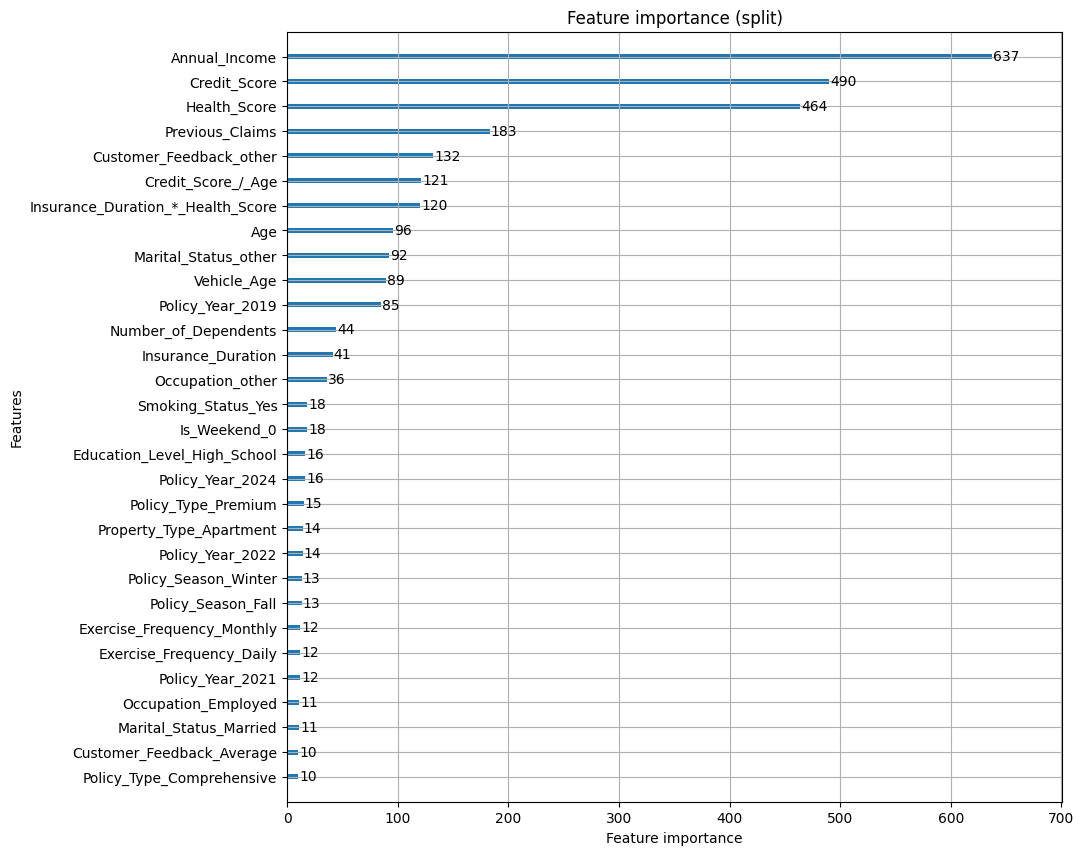

In [ ]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=30 ,importance_type='split', figsize=(10, 10), title='Feature importance (split)', xlabel='Feature importance', ylabel='Features')
plt.show()